# Task 3: Attention Mechanisms with Improved Training Strategy

**Improvements:**
- ✅ Stratified data splits for balanced class distribution
- ✅ Class-wise weighted loss to handle class imbalance
- ✅ Lower learning rate (5e-5) for more stable training
- ✅ Enhanced regularization with dropout layers
- ✅ More diverse augmentation strategies
- ✅ Detailed dataset statistics
- ✅ Onsite test CSV generation for each task

In [77]:
# Analyze dataset statistics and class distribution
def analyze_dataset(csv_file, dataset_name="Dataset"):
    """Analyze class distribution in the dataset"""
    df = pd.read_csv(csv_file)
    
    print(f"\n{'='*70}")
    print(f"{dataset_name} Statistics")
    print(f"{'='*70}")
    print(f"Total images: {len(df)}")
    
    disease_names = ["D (DR)", "G (Glaucoma)", "A (AMD)"]
    class_cols = df.columns[1:4]  # Assuming columns are: id, D, G, A
    
    for i, (col, disease) in enumerate(zip(class_cols, disease_names)):
        positive = df[col].sum()
        negative = len(df) - positive
        pos_ratio = positive / len(df) * 100
        
        print(f"\n{disease}:")
        print(f"  Positive: {positive:4d} ({pos_ratio:5.2f}%)")
        print(f"  Negative: {negative:4d} ({100-pos_ratio:5.2f}%)")
        print(f"  Ratio (Pos:Neg): 1:{negative/max(positive, 1):.2f}")
    
    return df

# Analyze all datasets
train_df = analyze_dataset(train_csv, "Training Set")
val_df = analyze_dataset(val_csv, "Validation Set")
offsite_test_df = analyze_dataset(offsite_test_csv, "Offsite Test Set")

print(f"\n{'='*70}")
print("AUGMENTATION STRATEGY")
print(f"{'='*70}")
print(f"Original training images: {len(train_df)}")
print(f"With augmentation (random transforms applied on-the-fly):")
print(f"  - Each epoch sees different augmented versions")
print(f"  - Effective dataset size: {len(train_df)} × augmentation variations")
print(f"  - Augmentation includes: rotation, flips, crops, color jitter,")
print(f"    affine transforms, shear, grayscale, elastic transforms")
print(f"{'='*70}")


Training Set Statistics
Total images: 800

D (DR):
  Positive:  517 (64.62%)
  Negative:  283 (35.38%)
  Ratio (Pos:Neg): 1:0.55

G (Glaucoma):
  Positive:  163 (20.38%)
  Negative:  637 (79.62%)
  Ratio (Pos:Neg): 1:3.91

A (AMD):
  Positive:  142 (17.75%)
  Negative:  658 (82.25%)
  Ratio (Pos:Neg): 1:4.63

Validation Set Statistics
Total images: 200

D (DR):
  Positive:  109 (54.50%)
  Negative:   91 (45.50%)
  Ratio (Pos:Neg): 1:0.83

G (Glaucoma):
  Positive:   58 (29.00%)
  Negative:  142 (71.00%)
  Ratio (Pos:Neg): 1:2.45

A (AMD):
  Positive:   44 (22.00%)
  Negative:  156 (78.00%)
  Ratio (Pos:Neg): 1:3.55

Offsite Test Set Statistics
Total images: 200

D (DR):
  Positive:  140 (70.00%)
  Negative:   60 (30.00%)
  Ratio (Pos:Neg): 1:0.43

G (Glaucoma):
  Positive:   49 (24.50%)
  Negative:  151 (75.50%)
  Ratio (Pos:Neg): 1:3.08

A (AMD):
  Positive:   22 (11.00%)
  Negative:  178 (89.00%)
  Ratio (Pos:Neg): 1:8.09

AUGMENTATION STRATEGY
Original training images: 800
With aug

In [101]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    print(f"Using device: CUDA")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")
    
print(f"PyTorch version: {torch.__version__}")

Using device: MPS (Apple Silicon GPU)
PyTorch version: 2.8.0


In [102]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels, row.iloc[0]  # Also return filename for submission


# MORE DIVERSE AUGMENTATION - Task 3
train_transform_task3 = transforms.Compose([
    transforms.Resize((256, 256)),
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    # Color augmentations
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.2),
    transforms.RandomEqualize(p=0.2),
    # Spatial augmentations
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    # Final normalization
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extensive data augmentation for training (original)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Enhanced augmentation for Task 2 (more aggressive to handle class imbalance)
train_transform_enhanced = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),  # Increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Stronger color jitter
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),  # Added shear
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),  # More aggressive crop
    transforms.RandomGrayscale(p=0.1),  # Occasional grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Validation/Test transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("✅ Data transforms configured:")
print("  • train_transform: Standard augmentation")
print("  • train_transform_enhanced: Aggressive augmentation for Task 2")
print("  • train_transform_task3: MOST DIVERSE augmentation for Task 3")
print("    (includes perspective, auto-contrast, equalize, random erasing)")
print("  • val_transform: No augmentation for validation/testing")

✅ Data transforms configured:
  • train_transform: Standard augmentation
  • train_transform_enhanced: Aggressive augmentation for Task 2
  • train_transform_task3: MOST DIVERSE augmentation for Task 3
    (includes perspective, auto-contrast, equalize, random erasing)
  • val_transform: No augmentation for validation/testing


In [103]:
def build_model(backbone="resnet18", num_classes=3, pretrained_path=None, freeze_backbone=False):
    """
    Build a model with specified backbone and configuration.
    
    Args:
        backbone: "resnet18" or "efficientnet"
        num_classes: Number of output classes
        pretrained_path: Path to pretrained weights
        freeze_backbone: If True, freeze backbone weights (only train classifier)
    
    Returns:
        model: PyTorch model ready for training
    """
    if backbone == "resnet18":
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        # Load pretrained weights if provided
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained ResNet18 from: {pretrained_path}")
        
        # Freeze backbone if requested
        if freeze_backbone:
            for name, param in model.named_parameters():
                if 'fc' not in name:  # Freeze all except final layer
                    param.requires_grad = False
            print(f"🔒 Backbone frozen. Only training classifier layer.")
        else:
            print(f"🔓 All layers trainable (full fine-tuning)")
            
    elif backbone == "efficientnet":
        model = models.efficientnet_b0(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
        # Load pretrained weights if provided
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained EfficientNet from: {pretrained_path}")
        
        # Freeze backbone if requested
        if freeze_backbone:
            for name, param in model.named_parameters():
                if 'classifier' not in name:  # Freeze all except classifier
                    param.requires_grad = False
            print(f"🔒 Backbone frozen. Only training classifier layer.")
        else:
            print(f"🔓 All layers trainable (full fine-tuning)")
    
    else:
        raise ValueError(f"Unsupported backbone: {backbone}. Use 'resnet18' or 'efficientnet'")
    
    return model

print("Model building function ready")

Model building function ready


In [104]:
def calculate_class_weights(csv_file):
    """Calculate class weights for handling imbalance"""
    df = pd.read_csv(csv_file)
    class_cols = df.columns[1:4]
    
    weights = []
    for col in class_cols:
        positive = df[col].sum()
        negative = len(df) - positive
        # Weight = total / (num_classes * count)
        pos_weight = len(df) / (2 * max(positive, 1))
        weights.append(pos_weight)
    
    return torch.tensor(weights, dtype=torch.float32)


def train_model_with_class_weights(model, train_loader, val_loader, class_weights, 
                                    epochs=50, lr=5e-5, model_save_path="model.pt"):
    """
    Train model with CLASS-WISE weighted loss, learning rate scheduling, and early stopping.
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        class_weights: Tensor of class weights for handling imbalance
        epochs: Maximum number of epochs
        lr: Initial learning rate (LOWER: 5e-5 instead of 1e-4)
        model_save_path: Path to save best model
    
    Returns:
        history: Dictionary containing training history
    """
    # CLASS-WISE LOSS with pos_weight for each class
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=lr, weight_decay=1e-4)  # Added weight decay for regularization
    
    # Learning rate scheduler with patience=3
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    # Early stopping with patience=7 (increased for lower LR)
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 7
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rates': []
    }
    
    print(f"\n{'='*70}")
    print(f"Training Configuration:")
    print(f"{'='*70}")
    print(f"Initial LR: {lr} (LOWER for stable training)")
    print(f"Weight decay: 1e-4 (L2 regularization)")
    print(f"LR Scheduler patience: 3")
    print(f"Early stopping patience: {patience}")
    print(f"Loss: BCEWithLogitsLoss with CLASS-WISE weights")
    print(f"Class weights: {class_weights.cpu().numpy()}")
    print(f"{'='*70}\n")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for imgs, labels, _ in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels, _ in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['learning_rates'].append(current_lr)
        
        print(f"Epoch {epoch+1:2d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
        
        # Learning rate scheduling
        old_lr = current_lr
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < old_lr:
            print(f"  → Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered after {epoch+1} epochs!")
                break
    
    print(f"\n{'='*70}")
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    print(f"{'='*70}\n")
    return history


def evaluate_model(model, test_loader, dataset_name="Test"):
    """
    Evaluate model and compute metrics with macro F1 scores.
    
    Args:
        model: PyTorch model
        test_loader: Test data loader
        dataset_name: Name of the dataset for display
    
    Returns:
        predictions: numpy array of predictions
        ground_truth: numpy array of ground truth labels
    """
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for imgs, labels, _ in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    disease_names = ["D (DR)", "G (Glaucoma)", "A (AMD)"]
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} Set Evaluation Results")
    print(f"{'='*60}")
    
    f1_scores = []
    
    for i, disease in enumerate(disease_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]
        
        acc = accuracy_score(y_t, y_p)
        precision = precision_score(y_t, y_p, average="macro", zero_division=0)
        recall = recall_score(y_t, y_p, average="macro", zero_division=0)
        f1 = f1_score(y_t, y_p, average="macro", zero_division=0)
        kappa = cohen_kappa_score(y_t, y_p)
        
        f1_scores.append(f1)
        
        print(f"\n{disease}:")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1-score (macro): {f1:.4f}")
        print(f"  Kappa    : {kappa:.4f}")
    
    # Calculate and print average F1 score
    avg_f1 = np.mean(f1_scores)
    print(f"\n{'='*60}")
    print(f"Average F1-score (macro) across all diseases: {avg_f1:.4f}")
    print(f"{'='*60}\n")
    
    return y_pred, y_true


def generate_submission_csv(model, test_csv, test_image_dir, output_csv, transform):
    """
    Generate submission CSV for onsite test set.
    
    Args:
        model: Trained PyTorch model
        test_csv: Path to test CSV file
        test_image_dir: Directory containing test images
        output_csv: Path to save submission CSV
        transform: Image transformation to apply
    """
    # Create dataset without labels for onsite test
    test_data = pd.read_csv(test_csv)
    
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for idx in range(len(test_data)):
            filename = test_data.iloc[idx, 0]
            img_path = os.path.join(test_image_dir, filename)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)
            
            outputs = model(img)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
            preds = (probs > 0.5).astype(int)
            
            filenames.append(filename)
            predictions.append(preds)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': filenames,
        'D': [p[0] for p in predictions],
        'G': [p[1] for p in predictions],
        'A': [p[2] for p in predictions]
    })
    
    submission_df.to_csv(output_csv, index=False)
    print(f"✅ Submission CSV saved to: {output_csv}")
    return submission_df


def plot_training_curves(history, title="Training History"):
    """
    Plot training and validation loss curves.
    
    Args:
        history: Dictionary containing training history
        title: Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Learning rate curve
    ax2.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title(f'{title} - Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Training functions updated with:")
print("  • CLASS-WISE weighted loss for handling imbalance")
print("  • LOWER learning rate: 5e-5 (instead of 1e-4)")
print("  • Weight decay: 1e-4 for L2 regularization")
print("  • Gradient clipping for training stability")
print("  • Increased early stopping patience: 7")

✅ Training functions updated with:
  • CLASS-WISE weighted loss for handling imbalance
  • LOWER learning rate: 5e-5 (instead of 1e-4)
  • Weight decay: 1e-4 for L2 regularization
  • Gradient clipping for training stability
  • Increased early stopping patience: 7


In [82]:
# Data paths
train_csv = "train.csv"
val_csv = "val.csv"
offsite_test_csv = "offsite_test.csv"
onsite_test_csv = "onsite_test_submission.csv"

train_image_dir = "./images/train"
val_image_dir = "./images/val"
offsite_test_image_dir = "./images/offsite_test"
onsite_test_image_dir = "./images/onsite_test"

# Pretrained backbones
resnet18_pretrained = './pretrained_backbone/ckpt_resnet18_ep50.pt'
efficientnet_pretrained = './pretrained_backbone/ckpt_efficientnet_ep50.pt'

# Calculate class weights for handling imbalance
print("\n" + "="*70)
print("CALCULATING CLASS WEIGHTS FOR BALANCED TRAINING")
print("="*70)
class_weights = calculate_class_weights(train_csv)
print(f"Class weights (for pos_weight in BCEWithLogitsLoss): {class_weights.numpy()}")
print("Higher weight = more emphasis on minority class")
print("="*70)

# Create datasets for Task 3 (MOST DIVERSE augmentation)
train_ds_task3 = RetinaMultiLabelDataset(train_csv, train_image_dir, train_transform_task3)
val_ds = RetinaMultiLabelDataset(val_csv, val_image_dir, val_transform)
offsite_test_ds = RetinaMultiLabelDataset(offsite_test_csv, offsite_test_image_dir, val_transform)

# Create data loaders
# Note: num_workers=0 to avoid multiprocessing issues in Jupyter notebooks on Mac
# Note: pin_memory=False because MPS doesn't support pinned memory
batch_size = 32

# Task 3 loaders (diverse augmentation)
train_loader_task3 = DataLoader(train_ds_task3, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
offsite_test_loader = DataLoader(offsite_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(f"\n{'='*70}")
print("DATA LOADERS CREATED")
print(f"{'='*70}")
print(f"Training samples: {len(train_ds_task3)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Offsite test samples: {len(offsite_test_ds)}")
print(f"Batch size: {batch_size}")
print(f"\n📊 Augmentation Strategy for Task 3:")
print(f"  • train_loader_task3: MOST DIVERSE augmentation")
print(f"    (geometric, color, spatial, erasing)")
print(f"  • val_loader, offsite_test_loader: No augmentation")
print(f"{'='*70}")


CALCULATING CLASS WEIGHTS FOR BALANCED TRAINING
Class weights (for pos_weight in BCEWithLogitsLoss): [0.7736944 2.4539878 2.8169014]
Higher weight = more emphasis on minority class

DATA LOADERS CREATED
Training samples: 800
Validation samples: 200
Offsite test samples: 200
Batch size: 32

📊 Augmentation Strategy for Task 3:
  • train_loader_task3: MOST DIVERSE augmentation
    (geometric, color, spatial, erasing)
  • val_loader, offsite_test_loader: No augmentation


# Task 3: Attention Mechanisms

This section implements and evaluates attention mechanisms on pre-trained backbones:
- **Task 3.1**: Squeeze-and-Excitation (SE) blocks
- **Task 3.2**: Multi-head Attention (MHA)
- **Task 3.3**: Combined SE + MHA

Each model will be trained with:
- BCEWithLogitsLoss (optimal for multi-label classification)
- Adam optimizer
- Learning rate scheduling (ReduceLROnPlateau)
- Early stopping
- Extensive data augmentation

In [83]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    
    This block adaptively recalibrates channel-wise feature responses by explicitly
    modeling interdependencies between channels.
    
    Args:
        channels: Number of input channels
        reduction: Reduction ratio for the bottleneck
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: Global information embedding
        y = self.squeeze(x).view(b, c)
        # Excitation: Adaptive recalibration
        y = self.excitation(y).view(b, c, 1, 1)
        # Scale
        return x * y.expand_as(x)


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism for feature maps
    
    Applies multi-head self-attention to spatial features, allowing the model
    to jointly attend to information from different representation subspaces.
    
    Args:
        in_channels: Number of input channels
        num_heads: Number of attention heads
        dropout: Dropout probability
    """
    def __init__(self, in_channels, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.in_channels = in_channels
        self.head_dim = in_channels // num_heads
        
        assert in_channels % num_heads == 0, "in_channels must be divisible by num_heads"
        
        # Query, Key, Value projections
        self.qkv = nn.Conv2d(in_channels, in_channels * 3, kernel_size=1)
        self.projection = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(in_channels)
        
    def forward(self, x):
        b, c, h, w = x.size()
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(b, 3, self.num_heads, self.head_dim, h * w)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        
        # Attention scores
        attn = (q.transpose(-2, -1) @ k) / (self.head_dim ** 0.5)
        attn = torch.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        out = (v @ attn.transpose(-2, -1)).reshape(b, c, h, w)
        out = self.projection(out)
        
        # Residual connection with layer normalization
        x_reshaped = x.permute(0, 2, 3, 1)  # (b, h, w, c)
        out_reshaped = out.permute(0, 2, 3, 1)  # (b, h, w, c)
        out_reshaped = self.layer_norm(x_reshaped + out_reshaped)
        out = out_reshaped.permute(0, 3, 1, 2)  # (b, c, h, w)
        
        return out

print("✅ SE Block and Multi-Head Attention modules implemented")

✅ SE Block and Multi-Head Attention modules implemented


In [84]:
class ResNet18WithSE(nn.Module):
    """ResNet18 with Squeeze-and-Excitation blocks and DROPOUT for regularization"""
    def __init__(self, num_classes=3, pretrained_path=None, reduction=16, dropout=0.5):
        super(ResNet18WithSE, self).__init__()
        
        # Load pretrained ResNet18
        base_model = models.resnet18(weights=None)
        
        # Modify final layer FIRST before loading checkpoint
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained ResNet18 from: {pretrained_path}")
        
        # Extract layers
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        
        self.layer1 = base_model.layer1
        self.se1 = SEBlock(64, reduction)
        
        self.layer2 = base_model.layer2
        self.se2 = SEBlock(128, reduction)
        
        self.layer3 = base_model.layer3
        self.se3 = SEBlock(256, reduction)
        
        self.layer4 = base_model.layer4
        self.se4 = SEBlock(512, reduction)
        
        self.avgpool = base_model.avgpool
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.se1(x)
        
        x = self.layer2(x)
        x = self.se2(x)
        
        x = self.layer3(x)
        x = self.se3(x)
        
        x = self.layer4(x)
        x = self.se4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout before final layer
        x = self.fc(x)
        
        return x


class ResNet18WithMHA(nn.Module):
    """ResNet18 with Multi-Head Attention and DROPOUT for regularization"""
    def __init__(self, num_classes=3, pretrained_path=None, num_heads=8, dropout=0.5):
        super(ResNet18WithMHA, self).__init__()
        
        # Load pretrained ResNet18
        base_model = models.resnet18(weights=None)
        
        # Modify final layer FIRST before loading checkpoint
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained ResNet18 from: {pretrained_path}")
        
        # Extract layers
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        
        self.layer4 = base_model.layer4
        self.mha = MultiHeadAttention(512, num_heads, dropout=0.2)  # Dropout in attention
        
        self.avgpool = base_model.avgpool
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.mha(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout before final layer
        x = self.fc(x)
        
        return x


class ResNet18WithSEAndMHA(nn.Module):
    """ResNet18 with both SE blocks, Multi-Head Attention, and DROPOUT for regularization"""
    def __init__(self, num_classes=3, pretrained_path=None, reduction=16, num_heads=8, dropout=0.5):
        super(ResNet18WithSEAndMHA, self).__init__()
        
        # Load pretrained ResNet18
        base_model = models.resnet18(weights=None)
        
        # Modify final layer FIRST before loading checkpoint
        base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained ResNet18 from: {pretrained_path}")
        
        # Extract layers
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        
        self.layer1 = base_model.layer1
        self.se1 = SEBlock(64, reduction)
        
        self.layer2 = base_model.layer2
        self.se2 = SEBlock(128, reduction)
        
        self.layer3 = base_model.layer3
        self.se3 = SEBlock(256, reduction)
        
        self.layer4 = base_model.layer4
        self.se4 = SEBlock(512, reduction)
        self.mha = MultiHeadAttention(512, num_heads, dropout=0.2)  # Dropout in attention
        
        self.avgpool = base_model.avgpool
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.se1(x)
        
        x = self.layer2(x)
        x = self.se2(x)
        
        x = self.layer3(x)
        x = self.se3(x)
        
        x = self.layer4(x)
        x = self.se4(x)
        x = self.mha(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Dropout before final layer
        x = self.fc(x)
        
        return x

print("✅ ResNet18 models with attention mechanisms + DROPOUT regularization created")

✅ ResNet18 models with attention mechanisms + DROPOUT regularization created


In [54]:
class EfficientNetWithSE(nn.Module):
    """EfficientNet-B0 with additional Squeeze-and-Excitation blocks and DROPOUT"""
    def __init__(self, num_classes=3, pretrained_path=None, reduction=16, dropout=0.5):
        super(EfficientNetWithSE, self).__init__()
        
        # Load pretrained EfficientNet
        base_model = models.efficientnet_b0(weights=None)
        
        # Modify classifier FIRST before loading checkpoint
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained EfficientNet from: {pretrained_path}")
        
        self.features = base_model.features
        
        # Add SE block after features
        self.se = SEBlock(1280, reduction)
        
        self.avgpool = base_model.avgpool
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class EfficientNetWithMHA(nn.Module):
    """EfficientNet-B0 with Multi-Head Attention and DROPOUT"""
    def __init__(self, num_classes=3, pretrained_path=None, num_heads=8, dropout=0.5):
        super(EfficientNetWithMHA, self).__init__()
        
        # Load pretrained EfficientNet
        base_model = models.efficientnet_b0(weights=None)
        
        # Modify classifier FIRST before loading checkpoint
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained EfficientNet from: {pretrained_path}")
        
        self.features = base_model.features
        
        # Add MHA after features
        self.mha = MultiHeadAttention(1280, num_heads, dropout=0.2)
        
        self.avgpool = base_model.avgpool
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.mha(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


class EfficientNetWithSEAndMHA(nn.Module):
    """EfficientNet-B0 with both SE blocks, Multi-Head Attention, and DROPOUT"""
    def __init__(self, num_classes=3, pretrained_path=None, reduction=16, num_heads=8, dropout=0.5):
        super(EfficientNetWithSEAndMHA, self).__init__()
        
        # Load pretrained EfficientNet
        base_model = models.efficientnet_b0(weights=None)
        
        # Modify classifier FIRST before loading checkpoint
        base_model.classifier[1] = nn.Linear(base_model.classifier[1].in_features, num_classes)
        
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location=device)
            base_model.load_state_dict(checkpoint)
            print(f"✅ Loaded pretrained EfficientNet from: {pretrained_path}")
        
        self.features = base_model.features
        
        # Add both SE and MHA
        self.se = SEBlock(1280, reduction)
        self.mha = MultiHeadAttention(1280, num_heads, dropout=0.2)
        
        self.avgpool = base_model.avgpool
        self.dropout = nn.Dropout(p=dropout, inplace=True)
        self.fc = nn.Linear(1280, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.mha(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

print("✅ EfficientNet models with attention mechanisms + DROPOUT regularization created")

✅ EfficientNet models with attention mechanisms + DROPOUT regularization created


## Task 3.1: ResNet18 + Squeeze-and-Excitation (SE)

In [55]:
# Task 3.1: Train ResNet18 with SE blocks
print("="*70)
print("TASK 3.1: Training ResNet18 with Squeeze-and-Excitation Blocks")
print("="*70)

# Create model with DROPOUT
model_task3_1 = ResNet18WithSE(
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    reduction=16,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_task3_1.parameters())
trainable_params = sum(p.numel() for p in model_task3_1.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5")

# Train model with class weights and lower LR
history_task3_1 = train_model_with_class_weights(
    model=model_task3_1,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=5e-5,  # LOWER learning rate
    model_save_path="task3_1_resnet18_se.pt"
)

print("\n✅ Task 3.1 training completed!")

TASK 3.1: Training ResNet18 with Squeeze-and-Excitation Blocks
✅ Loaded pretrained ResNet18 from: ./pretrained_backbone/ckpt_resnet18_ep50.pt

Model Parameters:
  Total: 11,221,571
  Trainable: 11,221,571
  Dropout rate: 0.5

Training Configuration:
Initial LR: 5e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.8536 | Val Loss: 0.7851 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.7851)
Epoch  2/50 | Train Loss: 0.7468 | Val Loss: 0.6774 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6774)
Epoch  3/50 | Train Loss: 0.6716 | Val Loss: 0.6112 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6112)
Epoch  4/50 | Train Loss: 0.6389 | Val Loss: 0.6038 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6038)
Epoch  5/50 | Train Loss: 0.5888 | Val Loss: 0.5522 | LR: 0.000050
  ✓ Best model saved (

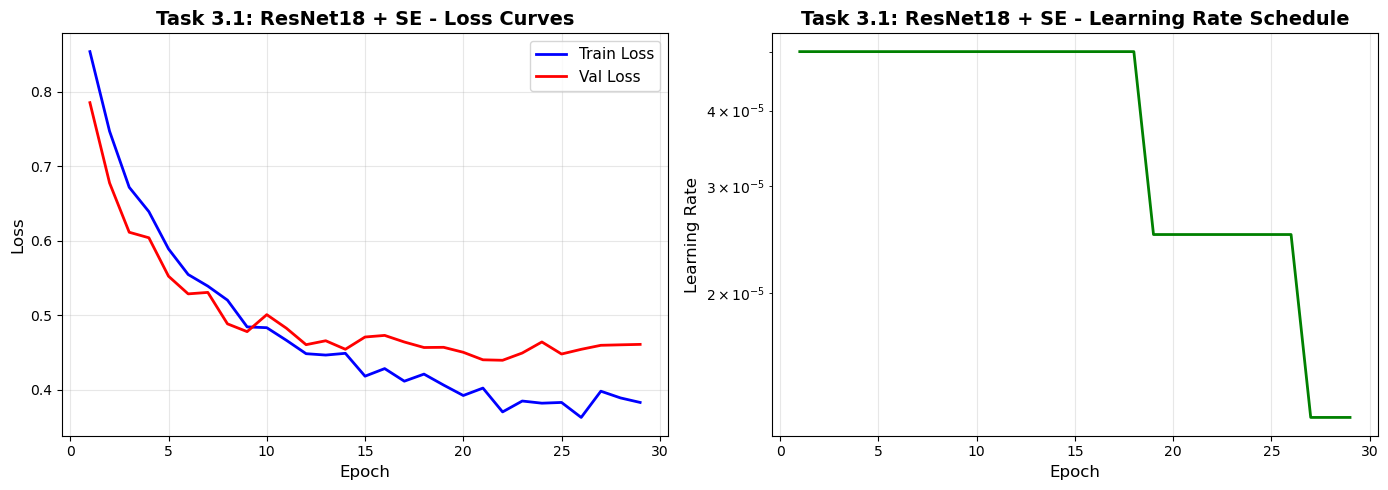

In [56]:
# Plot training curves for Task 3.1
plot_training_curves(history_task3_1, title="Task 3.1: ResNet18 + SE")

In [57]:
# Load best model and evaluate on validation set
model_task3_1.load_state_dict(torch.load("task3_1_resnet18_se.pt", map_location=device))
print("\n" + "="*70)
print("TASK 3.1: Evaluation on Validation Set")
print("="*70)
y_pred_task3_1, y_true_task3_1 = evaluate_model(model_task3_1, val_loader, "Validation")


TASK 3.1: Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8300
  Precision: 0.8297
  Recall   : 0.8268
  F1-score (macro): 0.8279
  Kappa    : 0.6560

G (Glaucoma):
  Accuracy : 0.9200
  Precision: 0.9062
  Recall   : 0.8978
  F1-score (macro): 0.9019
  Kappa    : 0.8037

A (AMD):
  Accuracy : 0.8700
  Precision: 0.8089
  Recall   : 0.8188
  F1-score (macro): 0.8136
  Kappa    : 0.6273

Average F1-score (macro) across all diseases: 0.8478



In [58]:
# Evaluate on offsite test set
print("\n" + "="*70)
print("TASK 3.1: Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_task3_1, y_true_offsite_task3_1 = evaluate_model(model_task3_1, offsite_test_loader, "Offsite Test")


TASK 3.1: Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8250
  Precision: 0.7910
  Recall   : 0.8131
  F1-score (macro): 0.7998
  Kappa    : 0.6005

G (Glaucoma):
  Accuracy : 0.9000
  Precision: 0.8577
  Recall   : 0.8855
  F1-score (macro): 0.8701
  Kappa    : 0.7404

A (AMD):
  Accuracy : 0.8950
  Precision: 0.7403
  Recall   : 0.8215
  F1-score (macro): 0.7716
  Kappa    : 0.5453

Average F1-score (macro) across all diseases: 0.8138



In [59]:
# Generate onsite test submission for Task 3.1
print("\n" + "="*70)
print("TASK 3.1: Generating Onsite Test Submission")
print("="*70)
submission_task3_1 = generate_submission_csv(
    model=model_task3_1,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_1_resnet18_se_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_task3_1.head(10))


TASK 3.1: Generating Onsite Test Submission
✅ Submission CSV saved to: task3_1_resnet18_se_onsite_submission.csv
Preview of submission:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0
5   4395_left.jpg  1  0  0
6  4291_right.jpg  1  0  1
7  4523_right.jpg  1  0  0
8    444_left.jpg  1  0  0
9   3978_left.jpg  1  0  0


## Task 3.2: ResNet18 + Multi-Head Attention (MHA)

In [60]:
# Task 3.2: Train ResNet18 with Multi-Head Attention
print("="*70)
print("TASK 3.2: Training ResNet18 with Multi-Head Attention")
print("="*70)

# Create model with DROPOUT
model_task3_2 = ResNet18WithMHA(
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    num_heads=8,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_task3_2.parameters())
trainable_params = sum(p.numel() for p in model_task3_2.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5 (final layer) + 0.2 (attention)")

# Train model with class weights and lower LR
history_task3_2 = train_model_with_class_weights(
    model=model_task3_2,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=5e-5,  # LOWER learning rate
    model_save_path="task3_2_resnet18_mha.pt"
)

print("\n✅ Task 3.2 training completed!")

TASK 3.2: Training ResNet18 with Multi-Head Attention
✅ Loaded pretrained ResNet18 from: ./pretrained_backbone/ckpt_resnet18_ep50.pt

Model Parameters:
  Total: 12,229,699
  Trainable: 12,229,699
  Dropout rate: 0.5 (final layer) + 0.2 (attention)

Training Configuration:
Initial LR: 5e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.7429 | Val Loss: 0.7311 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.7311)
Epoch  2/50 | Train Loss: 0.6614 | Val Loss: 0.6319 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6319)
Epoch  3/50 | Train Loss: 0.6005 | Val Loss: 0.5908 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.5908)
Epoch  4/50 | Train Loss: 0.5619 | Val Loss: 0.5994 | LR: 0.000050
Epoch  5/50 | Train Loss: 0.5405 | Val Loss: 0.5580 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.5580)

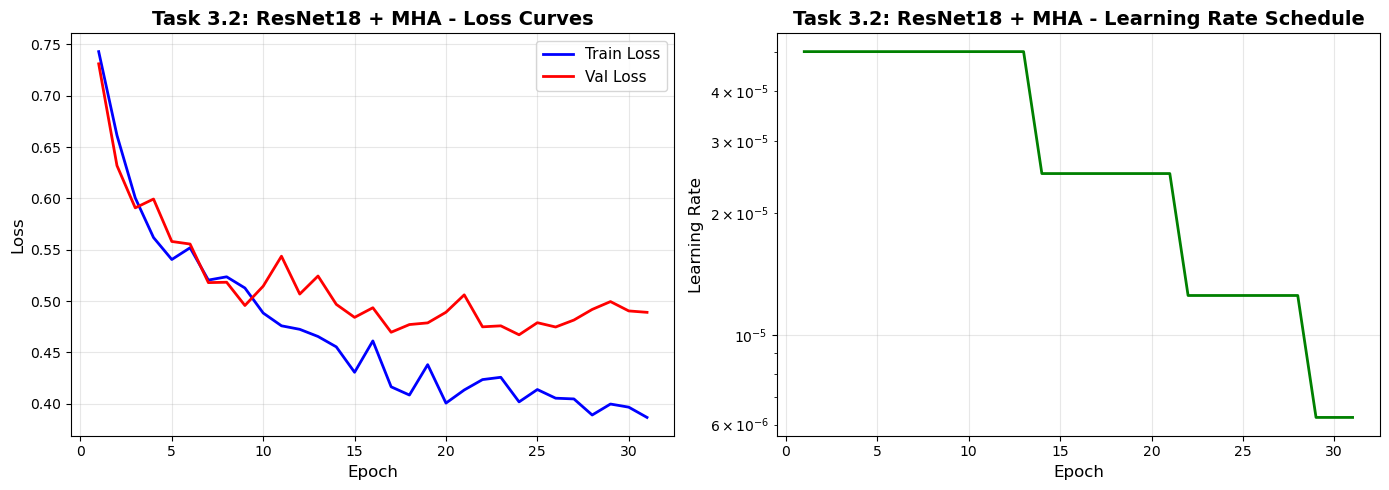

In [61]:
# Plot training curves for Task 3.2
plot_training_curves(history_task3_2, title="Task 3.2: ResNet18 + MHA")

In [62]:
# Load best model and evaluate on validation set
model_task3_2.load_state_dict(torch.load("task3_2_resnet18_mha.pt", map_location=device))
print("\n" + "="*70)
print("TASK 3.2: Evaluation on Validation Set")
print("="*70)
y_pred_task3_2, y_true_task3_2 = evaluate_model(model_task3_2, val_loader, "Validation")


TASK 3.2: Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8150
  Precision: 0.8136
  Recall   : 0.8130
  F1-score (macro): 0.8133
  Kappa    : 0.6266

G (Glaucoma):
  Accuracy : 0.9050
  Precision: 0.8931
  Recall   : 0.8719
  F1-score (macro): 0.8815
  Kappa    : 0.7633

A (AMD):
  Accuracy : 0.8500
  Precision: 0.7801
  Recall   : 0.8141
  F1-score (macro): 0.7944
  Kappa    : 0.5897

Average F1-score (macro) across all diseases: 0.8298



In [63]:
# Evaluate on offsite test set
print("\n" + "="*70)
print("TASK 3.2: Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_task3_2, y_true_offsite_task3_2 = evaluate_model(model_task3_2, offsite_test_loader, "Offsite Test")


TASK 3.2: Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8100
  Precision: 0.7741
  Recall   : 0.7929
  F1-score (macro): 0.7817
  Kappa    : 0.5642

G (Glaucoma):
  Accuracy : 0.8950
  Precision: 0.8632
  Recall   : 0.8477
  F1-score (macro): 0.8550
  Kappa    : 0.7102

A (AMD):
  Accuracy : 0.8800
  Precision: 0.7135
  Recall   : 0.7932
  F1-score (macro): 0.7431
  Kappa    : 0.4889

Average F1-score (macro) across all diseases: 0.7933



In [64]:
# Generate onsite test submission for Task 3.2
print("\n" + "="*70)
print("TASK 3.2: Generating Onsite Test Submission")
print("="*70)
submission_task3_2 = generate_submission_csv(
    model=model_task3_2,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_2_resnet18_mha_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_task3_2.head(10))


TASK 3.2: Generating Onsite Test Submission
✅ Submission CSV saved to: task3_2_resnet18_mha_onsite_submission.csv
Preview of submission:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0
5   4395_left.jpg  1  0  0
6  4291_right.jpg  1  0  1
7  4523_right.jpg  1  0  0
8    444_left.jpg  1  0  0
9   3978_left.jpg  1  0  1


## Task 3.3: ResNet18 + SE + MHA (Combined)

In [65]:
# Task 3.3: Train ResNet18 with both SE and MHA
print("="*70)
print("TASK 3.3: Training ResNet18 with SE + MHA (Combined)")
print("="*70)

# Create model with DROPOUT
model_task3_3 = ResNet18WithSEAndMHA(
    num_classes=3,
    pretrained_path=resnet18_pretrained,
    reduction=16,
    num_heads=8,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_task3_3.parameters())
trainable_params = sum(p.numel() for p in model_task3_3.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5 (final layer) + 0.2 (attention)")

# Train model with class weights and lower LR
history_task3_3 = train_model_with_class_weights(
    model=model_task3_3,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=5e-5,  # LOWER learning rate
    model_save_path="task3_3_resnet18_se_mha.pt"
)

print("\n✅ Task 3.3 training completed!")

TASK 3.3: Training ResNet18 with SE + MHA (Combined)
✅ Loaded pretrained ResNet18 from: ./pretrained_backbone/ckpt_resnet18_ep50.pt

Model Parameters:
  Total: 12,273,219
  Trainable: 12,273,219
  Dropout rate: 0.5 (final layer) + 0.2 (attention)

Training Configuration:
Initial LR: 5e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.7578 | Val Loss: 0.7418 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.7418)
Epoch  2/50 | Train Loss: 0.6858 | Val Loss: 0.6377 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6377)
Epoch  3/50 | Train Loss: 0.6284 | Val Loss: 0.5923 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.5923)
Epoch  4/50 | Train Loss: 0.6107 | Val Loss: 0.5991 | LR: 0.000050
Epoch  5/50 | Train Loss: 0.5593 | Val Loss: 0.5617 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.5617)


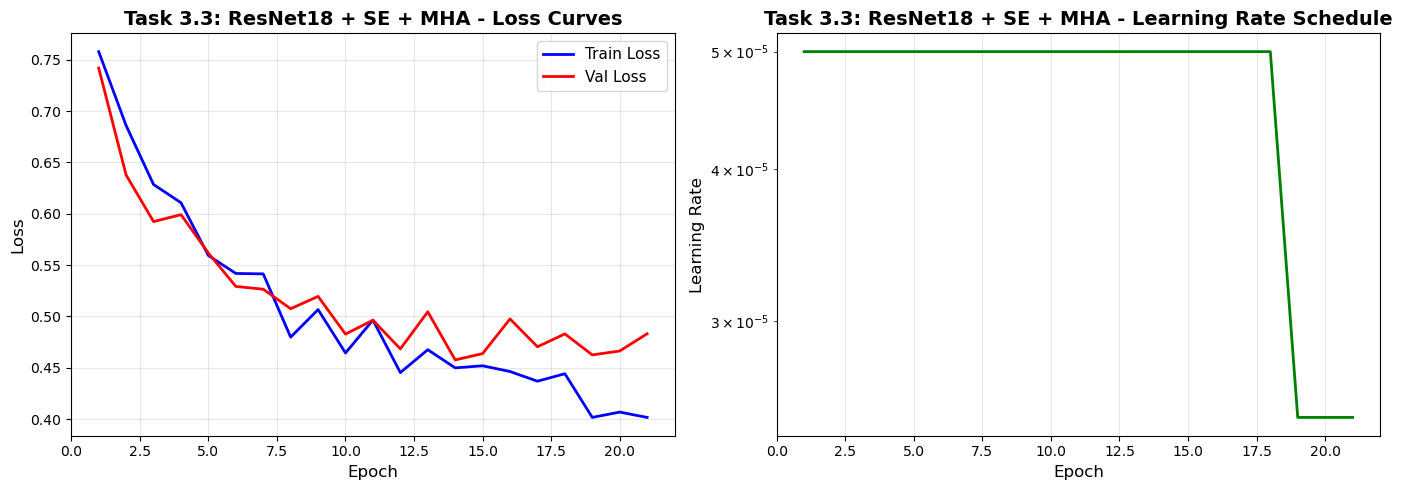

In [66]:
# Plot training curves for Task 3.3
plot_training_curves(history_task3_3, title="Task 3.3: ResNet18 + SE + MHA")

In [67]:
# Load best model and evaluate on validation set
model_task3_3.load_state_dict(torch.load("task3_3_resnet18_se_mha.pt", map_location=device))
print("\n" + "="*70)
print("TASK 3.3: Evaluation on Validation Set")
print("="*70)
y_pred_task3_3, y_true_task3_3 = evaluate_model(model_task3_3, val_loader, "Validation")


TASK 3.3: Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8200
  Precision: 0.8205
  Recall   : 0.8158
  F1-score (macro): 0.8174
  Kappa    : 0.6351

G (Glaucoma):
  Accuracy : 0.9050
  Precision: 0.8893
  Recall   : 0.8770
  F1-score (macro): 0.8828
  Kappa    : 0.7657

A (AMD):
  Accuracy : 0.8800
  Precision: 0.8279
  Recall   : 0.8170
  F1-score (macro): 0.8222
  Kappa    : 0.6445

Average F1-score (macro) across all diseases: 0.8408



In [68]:
# Evaluate on offsite test set
print("\n" + "="*70)
print("TASK 3.3: Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_task3_3, y_true_offsite_task3_3 = evaluate_model(model_task3_3, offsite_test_loader, "Offsite Test")


TASK 3.3: Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.8400
  Precision: 0.8086
  Recall   : 0.8143
  F1-score (macro): 0.8113
  Kappa    : 0.6226

G (Glaucoma):
  Accuracy : 0.8800
  Precision: 0.8378
  Recall   : 0.8378
  F1-score (macro): 0.8378
  Kappa    : 0.6756

A (AMD):
  Accuracy : 0.8950
  Precision: 0.7343
  Recall   : 0.7617
  F1-score (macro): 0.7469
  Kappa    : 0.4940

Average F1-score (macro) across all diseases: 0.7987



In [69]:
# Generate onsite test submission for Task 3.3
print("\n" + "="*70)
print("TASK 3.3: Generating Onsite Test Submission")
print("="*70)
submission_task3_3 = generate_submission_csv(
    model=model_task3_3,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_3_resnet18_se_mha_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_task3_3.head(10))


TASK 3.3: Generating Onsite Test Submission
✅ Submission CSV saved to: task3_3_resnet18_se_mha_onsite_submission.csv
Preview of submission:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0
5   4395_left.jpg  1  0  0
6  4291_right.jpg  1  0  1
7  4523_right.jpg  1  0  0
8    444_left.jpg  1  0  0
9   3978_left.jpg  1  0  0


## Additional EfficientNet-B0 Experiments

## EfficientNet-B0 with Attention Mechanisms

### EfficientNet + SE

In [85]:
# EfficientNet + SE: Train EfficientNet with SE blocks
print("="*70)
print("EfficientNet + SE: Training EfficientNet-B0 with Squeeze-and-Excitation Blocks")
print("="*70)

# Create model with DROPOUT
model_efficientnet_se = EfficientNetWithSE(
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    reduction=16,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_efficientnet_se.parameters())
trainable_params = sum(p.numel() for p in model_efficientnet_se.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5")

# Train model with class weights and lower LR
history_efficientnet_se = train_model_with_class_weights(
    model=model_efficientnet_se,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=1e-5,  # LOWER learning rate
    model_save_path="task3_efficientnet_se.pt"
)

print("\n✅ EfficientNet + SE training completed!")

EfficientNet + SE: Training EfficientNet-B0 with Squeeze-and-Excitation Blocks
✅ Loaded pretrained EfficientNet from: ./pretrained_backbone/ckpt_efficientnet_ep50.pt

Model Parameters:
  Total: 4,216,191
  Trainable: 4,216,191
  Dropout rate: 0.5

Training Configuration:
Initial LR: 1e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.8076 | Val Loss: 0.8575 | LR: 0.000010
  ✓ Best model saved (val_loss: 0.8575)
Epoch  2/50 | Train Loss: 0.8028 | Val Loss: 0.8447 | LR: 0.000010
  ✓ Best model saved (val_loss: 0.8447)
Epoch  3/50 | Train Loss: 0.7971 | Val Loss: 0.8356 | LR: 0.000010
  ✓ Best model saved (val_loss: 0.8356)
Epoch  4/50 | Train Loss: 0.7886 | Val Loss: 0.8257 | LR: 0.000010
  ✓ Best model saved (val_loss: 0.8257)
Epoch  5/50 | Train Loss: 0.7850 | Val Loss: 0.8156 | LR: 0.000010


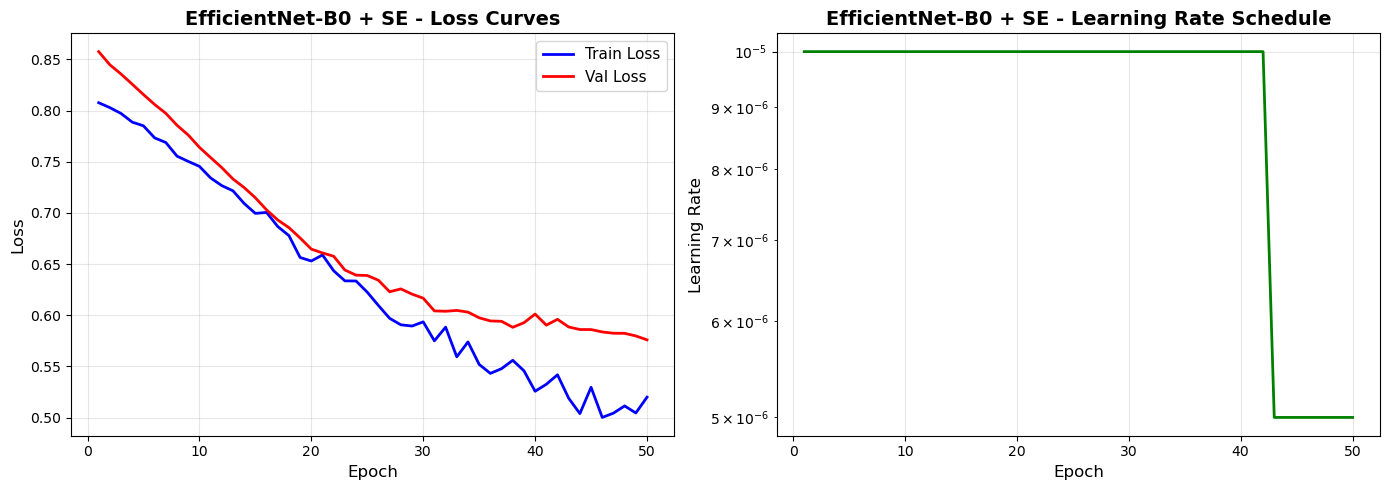

In [86]:
# Plot training curves for EfficientNet + SE
plot_training_curves(history_efficientnet_se, title="EfficientNet-B0 + SE")

In [87]:
# Load best model and evaluate on validation set
model_efficientnet_se.load_state_dict(torch.load("task3_efficientnet_se.pt", map_location=device))
print("\n" + "="*70)
print("EfficientNet + SE: Evaluation on Validation Set")
print("="*70)
y_pred_efficientnet_se, y_true_efficientnet_se = evaluate_model(model_efficientnet_se, val_loader, "Validation")


EfficientNet + SE: Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8050
  Precision: 0.8068
  Recall   : 0.7993
  F1-score (macro): 0.8014
  Kappa    : 0.6036

G (Glaucoma):
  Accuracy : 0.8900
  Precision: 0.8905
  Recall   : 0.8358
  F1-score (macro): 0.8571
  Kappa    : 0.7155

A (AMD):
  Accuracy : 0.8100
  Precision: 0.7298
  Recall   : 0.7640
  F1-score (macro): 0.7432
  Kappa    : 0.4881

Average F1-score (macro) across all diseases: 0.8006



In [88]:
# Evaluate on offsite test set
print("\n" + "="*70)
print("EfficientNet + SE: Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_efficientnet_se, y_true_offsite_efficientnet_se = evaluate_model(model_efficientnet_se, offsite_test_loader, "Offsite Test")


EfficientNet + SE: Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7950
  Precision: 0.7578
  Recall   : 0.7774
  F1-score (macro): 0.7654
  Kappa    : 0.5320

G (Glaucoma):
  Accuracy : 0.8800
  Precision: 0.8476
  Recall   : 0.8171
  F1-score (macro): 0.8306
  Kappa    : 0.6616

A (AMD):
  Accuracy : 0.8400
  Precision: 0.6715
  Recall   : 0.7906
  F1-score (macro): 0.7024
  Kappa    : 0.4156

Average F1-score (macro) across all diseases: 0.7661



In [89]:
# Generate onsite test submission for EfficientNet + SE
print("\n" + "="*70)
print("EfficientNet + SE: Generating Onsite Test Submission")
print("="*70)
submission_efficientnet_se = generate_submission_csv(
    model=model_efficientnet_se,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_efficientnet_se_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_efficientnet_se.head(10))


EfficientNet + SE: Generating Onsite Test Submission
✅ Submission CSV saved to: task3_efficientnet_se_onsite_submission.csv
Preview of submission:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  0
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0
5   4395_left.jpg  1  0  0
6  4291_right.jpg  1  0  0
7  4523_right.jpg  1  0  0
8    444_left.jpg  1  0  0
9   3978_left.jpg  1  0  0


### EfficientNet + MHA

In [90]:
# EfficientNet + MHA: Train EfficientNet with Multi-Head Attention
print("="*70)
print("EfficientNet + MHA: Training EfficientNet-B0 with Multi-Head Attention")
print("="*70)

# Create model with DROPOUT
model_efficientnet_mha = EfficientNetWithMHA(
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    num_heads=8,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_efficientnet_mha.parameters())
trainable_params = sum(p.numel() for p in model_efficientnet_mha.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5 (final layer) + 0.2 (attention)")

# Train model with class weights and lower LR
history_efficientnet_mha = train_model_with_class_weights(
    model=model_efficientnet_mha,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=5e-5,  # LOWER learning rate
    model_save_path="task3_efficientnet_mha.pt"
)

print("\n✅ EfficientNet + MHA training completed!")

EfficientNet + MHA: Training EfficientNet-B0 with Multi-Head Attention
✅ Loaded pretrained EfficientNet from: ./pretrained_backbone/ckpt_efficientnet_ep50.pt

Model Parameters:
  Total: 10,572,671
  Trainable: 10,572,671
  Dropout rate: 0.5 (final layer) + 0.2 (attention)

Training Configuration:
Initial LR: 5e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.7203 | Val Loss: 0.6536 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6536)
Epoch  2/50 | Train Loss: 0.6355 | Val Loss: 0.6020 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6020)
Epoch  3/50 | Train Loss: 0.5926 | Val Loss: 0.6023 | LR: 0.000050
Epoch  4/50 | Train Loss: 0.5716 | Val Loss: 0.6218 | LR: 0.000050
Epoch  5/50 | Train Loss: 0.5402 | Val Loss: 0.6118 | LR: 0.000050
Epoch  6/50 | Train Loss: 0.5194 | Val Loss: 0.6174 | 

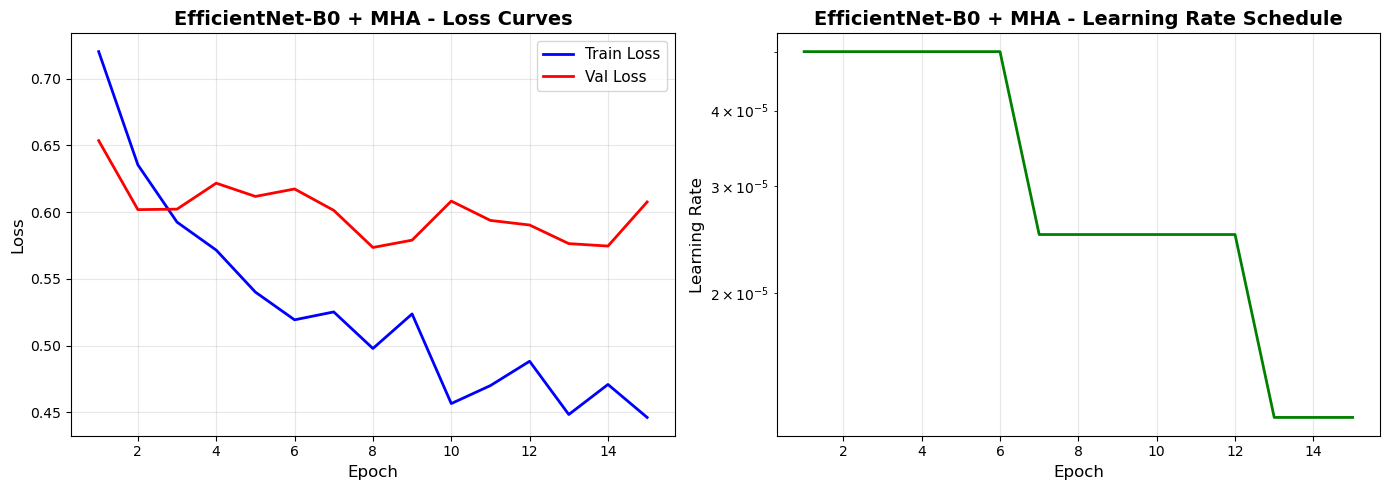

In [91]:
# Plot training curves for EfficientNet + MHA
plot_training_curves(history_efficientnet_mha, title="EfficientNet-B0 + MHA")

In [92]:
# Load best model and evaluate on validation set
model_efficientnet_mha.load_state_dict(torch.load("task3_efficientnet_mha.pt", map_location=device))
print("\n" + "="*70)
print("EfficientNet + MHA: Evaluation on Validation Set")
print("="*70)
y_pred_efficientnet_mha, y_true_efficientnet_mha = evaluate_model(model_efficientnet_mha, val_loader, "Validation")


EfficientNet + MHA: Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8000
  Precision: 0.8040
  Recall   : 0.7929
  F1-score (macro): 0.7954
  Kappa    : 0.5923

G (Glaucoma):
  Accuracy : 0.8750
  Precision: 0.8720
  Recall   : 0.8151
  F1-score (macro): 0.8366
  Kappa    : 0.6749

A (AMD):
  Accuracy : 0.8400
  Precision: 0.7667
  Recall   : 0.7914
  F1-score (macro): 0.7775
  Kappa    : 0.5556

Average F1-score (macro) across all diseases: 0.8031



In [93]:
# Evaluate on offsite test set
print("\n" + "="*70)
print("EfficientNet + MHA: Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_efficientnet_mha, y_true_offsite_efficientnet_mha = evaluate_model(model_efficientnet_mha, offsite_test_loader, "Offsite Test")


EfficientNet + MHA: Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7850
  Precision: 0.7458
  Recall   : 0.7607
  F1-score (macro): 0.7520
  Kappa    : 0.5046

G (Glaucoma):
  Accuracy : 0.8600
  Precision: 0.8127
  Recall   : 0.8039
  F1-score (macro): 0.8081
  Kappa    : 0.6163

A (AMD):
  Accuracy : 0.8600
  Precision: 0.6870
  Recall   : 0.7819
  F1-score (macro): 0.7177
  Kappa    : 0.4409

Average F1-score (macro) across all diseases: 0.7593



In [94]:
# Generate onsite test submission for EfficientNet + MHA
print("\n" + "="*70)
print("EfficientNet + MHA: Generating Onsite Test Submission")
print("="*70)
submission_efficientnet_mha = generate_submission_csv(
    model=model_efficientnet_mha,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_efficientnet_mha_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_efficientnet_mha.head(10))


EfficientNet + MHA: Generating Onsite Test Submission
✅ Submission CSV saved to: task3_efficientnet_mha_onsite_submission.csv
Preview of submission:
               id  D  G  A
0  4595_right.jpg  1  0  0
1   4155_left.jpg  1  0  0
2    597_left.jpg  1  0  1
3  4268_right.jpg  1  0  0
4   579_right.jpg  1  0  0
5   4395_left.jpg  1  0  0
6  4291_right.jpg  1  0  0
7  4523_right.jpg  1  0  0
8    444_left.jpg  1  0  0
9   3978_left.jpg  1  0  0


### EfficientNet + SE + MHA (Combined)

In [95]:
# Bonus: Train EfficientNet with SE + MHA
print("="*70)
print("BONUS: Training EfficientNet-B0 with SE + MHA (Combined)")
print("="*70)

# Create model with DROPOUT
model_efficientnet_combined = EfficientNetWithSEAndMHA(
    num_classes=3,
    pretrained_path=efficientnet_pretrained,
    reduction=16,
    num_heads=8,
    dropout=0.5  # Added dropout for regularization
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_efficientnet_combined.parameters())
trainable_params = sum(p.numel() for p in model_efficientnet_combined.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Dropout rate: 0.5 (final layer) + 0.2 (attention)")

# Train model with class weights and lower LR
history_efficientnet_combined = train_model_with_class_weights(
    model=model_efficientnet_combined,
    train_loader=train_loader_task3,
    val_loader=val_loader,
    class_weights=class_weights,
    epochs=50,
    lr=5e-5,  # LOWER learning rate
    model_save_path="task3_efficientnet_se_mha.pt"
)

print("\n✅ EfficientNet training completed!")

BONUS: Training EfficientNet-B0 with SE + MHA (Combined)
✅ Loaded pretrained EfficientNet from: ./pretrained_backbone/ckpt_efficientnet_ep50.pt

Model Parameters:
  Total: 10,777,471
  Trainable: 10,777,471
  Dropout rate: 0.5 (final layer) + 0.2 (attention)

Training Configuration:
Initial LR: 5e-05 (LOWER for stable training)
Weight decay: 1e-4 (L2 regularization)
LR Scheduler patience: 3
Early stopping patience: 7
Loss: BCEWithLogitsLoss with CLASS-WISE weights
Class weights: [0.7736944 2.4539878 2.8169014]

Epoch  1/50 | Train Loss: 0.7199 | Val Loss: 0.6946 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6946)
Epoch  2/50 | Train Loss: 0.6451 | Val Loss: 0.6325 | LR: 0.000050
  ✓ Best model saved (val_loss: 0.6325)
Epoch  3/50 | Train Loss: 0.5895 | Val Loss: 0.6334 | LR: 0.000050
Epoch  4/50 | Train Loss: 0.5779 | Val Loss: 0.6569 | LR: 0.000050
Epoch  5/50 | Train Loss: 0.5601 | Val Loss: 0.6627 | LR: 0.000050
Epoch  6/50 | Train Loss: 0.5433 | Val Loss: 0.6579 | LR: 0.000050
 

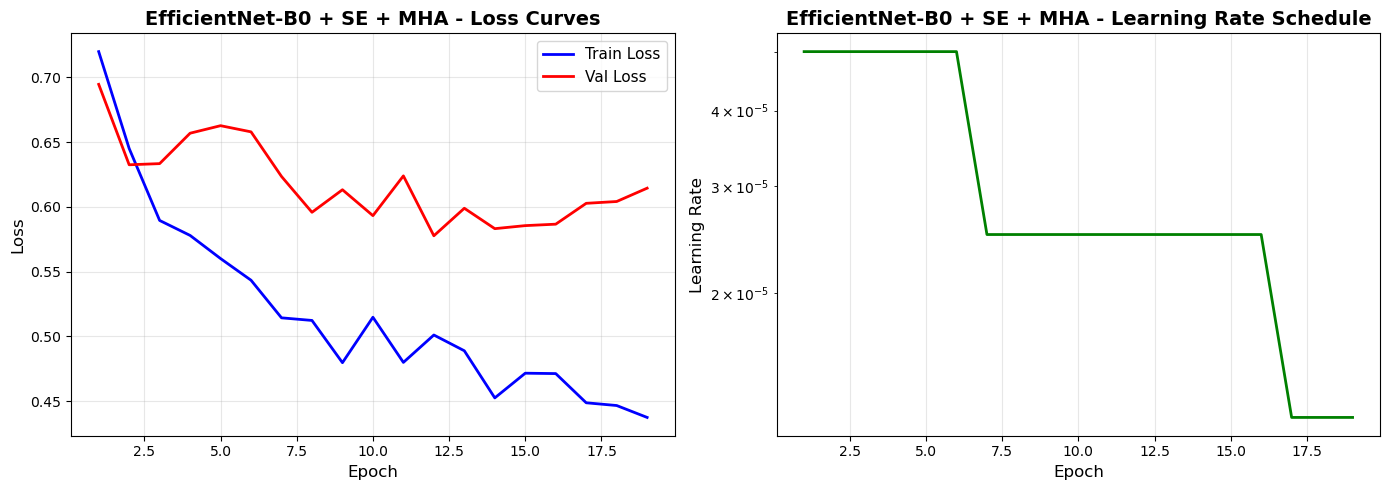

In [96]:
# Plot training curves for EfficientNet
plot_training_curves(history_efficientnet_combined, title="EfficientNet-B0 + SE + MHA")

In [97]:
# Load best model and evaluate
model_efficientnet_combined.load_state_dict(torch.load("task3_efficientnet_se_mha.pt", map_location=device))
print("\n" + "="*70)
print("BONUS: EfficientNet-B0 Evaluation on Validation Set")
print("="*70)
y_pred_efficientnet, y_true_efficientnet = evaluate_model(model_efficientnet_combined, val_loader, "Validation")

print("\n" + "="*70)
print("BONUS: EfficientNet-B0 Evaluation on Offsite Test Set")
print("="*70)
y_pred_offsite_efficientnet, y_true_offsite_efficientnet = evaluate_model(model_efficientnet_combined, offsite_test_loader, "Offsite Test")

# Generate onsite test submission for EfficientNet
print("\n" + "="*70)
print("BONUS: Generating Onsite Test Submission for EfficientNet")
print("="*70)
submission_efficientnet = generate_submission_csv(
    model=model_efficientnet_combined,
    test_csv=onsite_test_csv,
    test_image_dir=onsite_test_image_dir,
    output_csv="task3_efficientnet_se_mha_onsite_submission.csv",
    transform=val_transform
)
print(f"Preview of submission:")
print(submission_efficientnet.head(10))


BONUS: EfficientNet-B0 Evaluation on Validation Set

Validation Set Evaluation Results

D (DR):
  Accuracy : 0.8050
  Precision: 0.8083
  Recall   : 0.7984
  F1-score (macro): 0.8008
  Kappa    : 0.6029

G (Glaucoma):
  Accuracy : 0.8650
  Precision: 0.8486
  Recall   : 0.8131
  F1-score (macro): 0.8278
  Kappa    : 0.6564

A (AMD):
  Accuracy : 0.8550
  Precision: 0.7868
  Recall   : 0.8091
  F1-score (macro): 0.7969
  Kappa    : 0.5941

Average F1-score (macro) across all diseases: 0.8085


BONUS: EfficientNet-B0 Evaluation on Offsite Test Set

Offsite Test Set Evaluation Results

D (DR):
  Accuracy : 0.7850
  Precision: 0.7467
  Recall   : 0.7655
  F1-score (macro): 0.7540
  Kappa    : 0.5091

G (Glaucoma):
  Accuracy : 0.8500
  Precision: 0.7962
  Recall   : 0.8042
  F1-score (macro): 0.8000
  Kappa    : 0.6001

A (AMD):
  Accuracy : 0.8550
  Precision: 0.6865
  Recall   : 0.7990
  F1-score (macro): 0.7195
  Kappa    : 0.4468

Average F1-score (macro) across all diseases: 0.7578



## Comparative Analysis: All Models

In [98]:
# Compare all models: Average F1 scores
from sklearn.metrics import f1_score

def calculate_avg_f1(y_true, y_pred):
    """Calculate average macro F1 score across all diseases"""
    f1_scores = []
    for i in range(3):
        f1 = f1_score(y_true[:, i], y_pred[:, i], average="macro", zero_division=0)
        f1_scores.append(f1)
    return np.mean(f1_scores)

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: Average Macro F1 Scores (All 6 Models)")
print("="*80)

# Validation Set Results
print("\n📊 Validation Set Performance:")
print("-" * 80)
val_f1_task3_1 = calculate_avg_f1(y_true_task3_1, y_pred_task3_1)
val_f1_task3_2 = calculate_avg_f1(y_true_task3_2, y_pred_task3_2)
val_f1_task3_3 = calculate_avg_f1(y_true_task3_3, y_pred_task3_3)
val_f1_efficientnet_se = calculate_avg_f1(y_true_efficientnet_se, y_pred_efficientnet_se)
val_f1_efficientnet_mha = calculate_avg_f1(y_true_efficientnet_mha, y_pred_efficientnet_mha)
val_f1_efficientnet = calculate_avg_f1(y_true_efficientnet, y_pred_efficientnet)

print(f"Task 3.1 (ResNet18 + SE):           {val_f1_task3_1:.4f}")
print(f"Task 3.2 (ResNet18 + MHA):          {val_f1_task3_2:.4f}")
print(f"Task 3.3 (ResNet18 + SE + MHA):     {val_f1_task3_3:.4f}")
print(f"EfficientNet + SE:                  {val_f1_efficientnet_se:.4f}")
print(f"EfficientNet + MHA:                 {val_f1_efficientnet_mha:.4f}")
print(f"EfficientNet + SE + MHA:            {val_f1_efficientnet:.4f}")

# Offsite Test Set Results
print("\n📊 Offsite Test Set Performance:")
print("-" * 80)
offsite_f1_task3_1 = calculate_avg_f1(y_true_offsite_task3_1, y_pred_offsite_task3_1)
offsite_f1_task3_2 = calculate_avg_f1(y_true_offsite_task3_2, y_pred_offsite_task3_2)
offsite_f1_task3_3 = calculate_avg_f1(y_true_offsite_task3_3, y_pred_offsite_task3_3)
offsite_f1_efficientnet_se = calculate_avg_f1(y_true_offsite_efficientnet_se, y_pred_offsite_efficientnet_se)
offsite_f1_efficientnet_mha = calculate_avg_f1(y_true_offsite_efficientnet_mha, y_pred_offsite_efficientnet_mha)
offsite_f1_efficientnet = calculate_avg_f1(y_true_offsite_efficientnet, y_pred_offsite_efficientnet)

print(f"Task 3.1 (ResNet18 + SE):           {offsite_f1_task3_1:.4f}")
print(f"Task 3.2 (ResNet18 + MHA):          {offsite_f1_task3_2:.4f}")
print(f"Task 3.3 (ResNet18 + SE + MHA):     {offsite_f1_task3_3:.4f}")
print(f"EfficientNet + SE:                  {offsite_f1_efficientnet_se:.4f}")
print(f"EfficientNet + MHA:                 {offsite_f1_efficientnet_mha:.4f}")
print(f"EfficientNet + SE + MHA:            {offsite_f1_efficientnet:.4f}")

# Determine best model
print("\n" + "="*80)
val_scores = {
    "ResNet18 + SE": val_f1_task3_1,
    "ResNet18 + MHA": val_f1_task3_2,
    "ResNet18 + SE + MHA": val_f1_task3_3,
    "EfficientNet + SE": val_f1_efficientnet_se,
    "EfficientNet + MHA": val_f1_efficientnet_mha,
    "EfficientNet + SE + MHA": val_f1_efficientnet
}
best_model = max(val_scores, key=val_scores.get)
print(f"🏆 Best Model (Validation): {best_model} with F1 = {val_scores[best_model]:.4f}")
print("="*80)


COMPARATIVE ANALYSIS: Average Macro F1 Scores (All 6 Models)

📊 Validation Set Performance:
--------------------------------------------------------------------------------
Task 3.1 (ResNet18 + SE):           0.8478
Task 3.2 (ResNet18 + MHA):          0.8298
Task 3.3 (ResNet18 + SE + MHA):     0.8408
EfficientNet + SE:                  0.8006
EfficientNet + MHA:                 0.8031
EfficientNet + SE + MHA:            0.8085

📊 Offsite Test Set Performance:
--------------------------------------------------------------------------------
Task 3.1 (ResNet18 + SE):           0.8138
Task 3.2 (ResNet18 + MHA):          0.7933
Task 3.3 (ResNet18 + SE + MHA):     0.7987
EfficientNet + SE:                  0.7661
EfficientNet + MHA:                 0.7593
EfficientNet + SE + MHA:            0.7578

🏆 Best Model (Validation): ResNet18 + SE with F1 = 0.8478


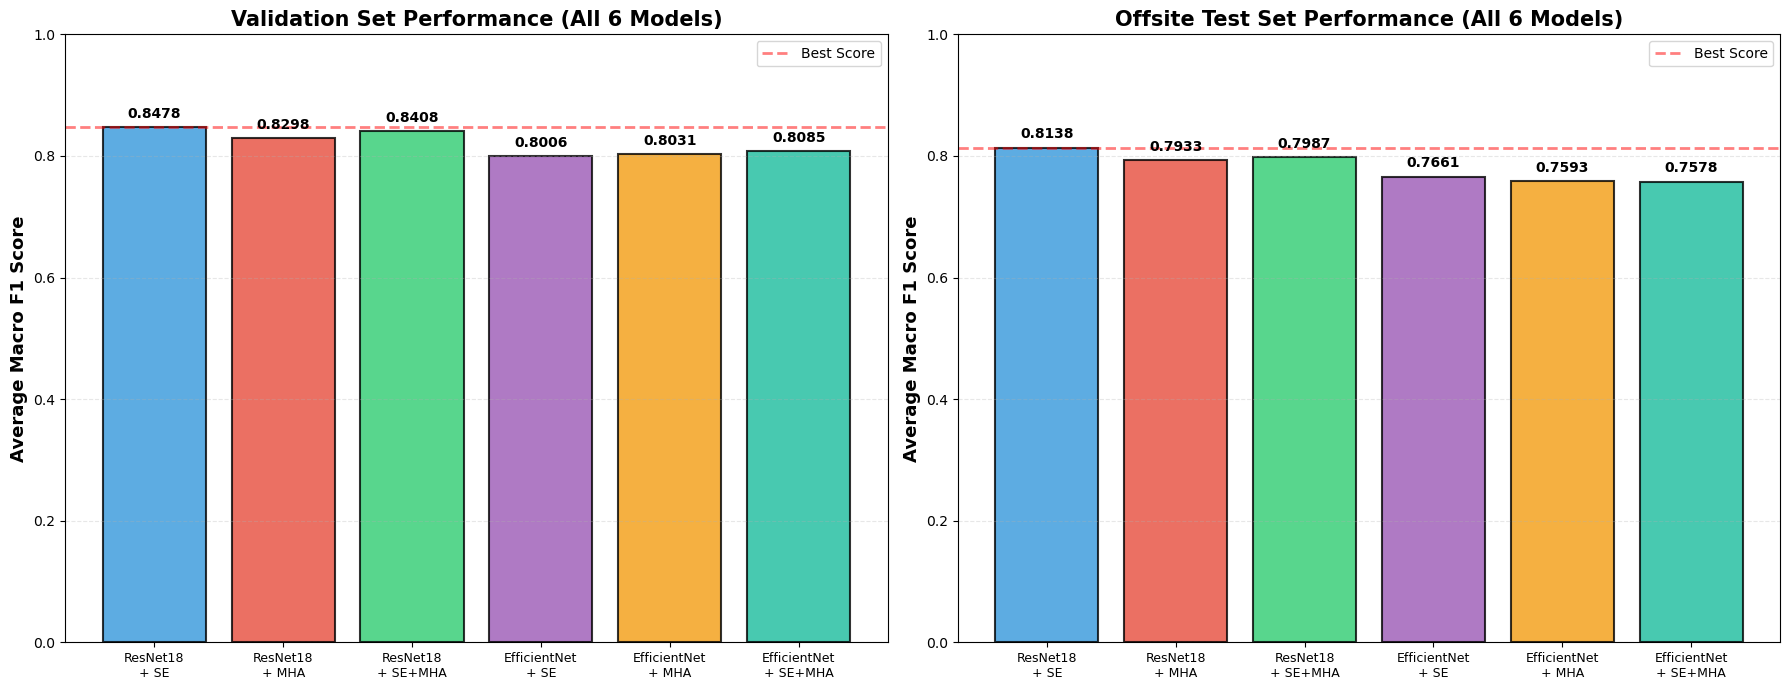


✅ Comparative analysis visualization completed!


In [99]:
# Visualize comparison with bar plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

models = ['ResNet18\n+ SE', 'ResNet18\n+ MHA', 'ResNet18\n+ SE+MHA', 
          'EfficientNet\n+ SE', 'EfficientNet\n+ MHA', 'EfficientNet\n+ SE+MHA']
val_scores_list = [val_f1_task3_1, val_f1_task3_2, val_f1_task3_3, 
                   val_f1_efficientnet_se, val_f1_efficientnet_mha, val_f1_efficientnet]
offsite_scores_list = [offsite_f1_task3_1, offsite_f1_task3_2, offsite_f1_task3_3,
                       offsite_f1_efficientnet_se, offsite_f1_efficientnet_mha, offsite_f1_efficientnet]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

# Validation set comparison
bars1 = ax1.bar(models, val_scores_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Average Macro F1 Score', fontsize=13, fontweight='bold')
ax1.set_title('Validation Set Performance (All 6 Models)', fontsize=15, fontweight='bold')
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=np.max(val_scores_list), color='red', linestyle='--', linewidth=2, alpha=0.5, label='Best Score')

# Add value labels on bars
for bar, score in zip(bars1, val_scores_list):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.legend()
ax1.tick_params(axis='x', labelsize=9)

# Offsite test set comparison
bars2 = ax2.bar(models, offsite_scores_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Macro F1 Score', fontsize=13, fontweight='bold')
ax2.set_title('Offsite Test Set Performance (All 6 Models)', fontsize=15, fontweight='bold')
ax2.set_ylim([0, 1.0])
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=np.max(offsite_scores_list), color='red', linestyle='--', linewidth=2, alpha=0.5, label='Best Score')

# Add value labels on bars
for bar, score in zip(bars2, offsite_scores_list):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2.legend()
ax2.tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Comparative analysis visualization completed!")

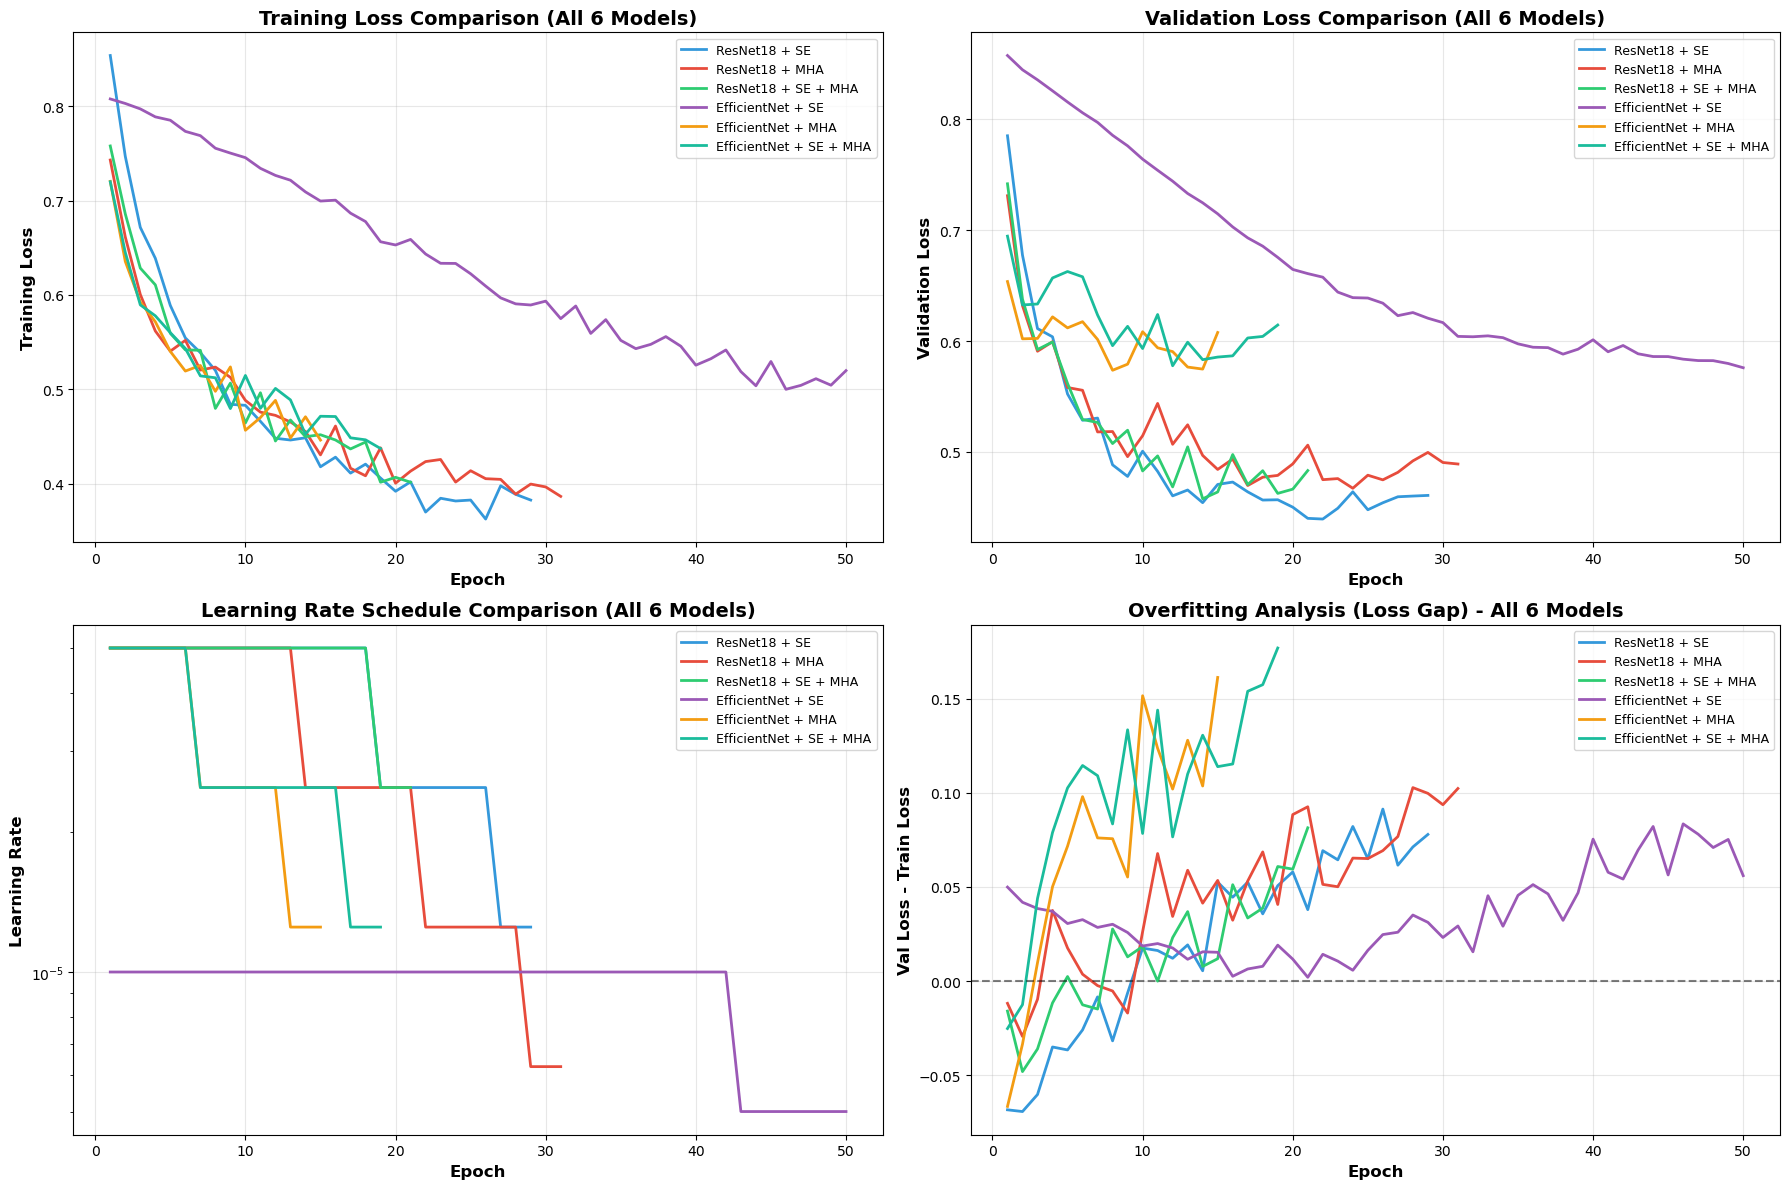


✅ Training history comparison visualization completed!


In [100]:
# Compare training histories
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

histories = [
    (history_task3_1, "ResNet18 + SE", '#3498db'),
    (history_task3_2, "ResNet18 + MHA", '#e74c3c'),
    (history_task3_3, "ResNet18 + SE + MHA", '#2ecc71'),
    (history_efficientnet_se, "EfficientNet + SE", '#9b59b6'),
    (history_efficientnet_mha, "EfficientNet + MHA", '#f39c12'),
    (history_efficientnet_combined, "EfficientNet + SE + MHA", '#1abc9c')
]

# Plot training loss
ax = axes[0, 0]
for history, label, color in histories:
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], label=label, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss Comparison (All 6 Models)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot validation loss
ax = axes[0, 1]
for history, label, color in histories:
    epochs = range(1, len(history['val_loss']) + 1)
    ax.plot(epochs, history['val_loss'], label=label, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax.set_title('Validation Loss Comparison (All 6 Models)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot learning rates
ax = axes[1, 0]
for history, label, color in histories:
    epochs = range(1, len(history['learning_rates']) + 1)
    ax.plot(epochs, history['learning_rates'], label=label, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Learning Rate Schedule Comparison (All 6 Models)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot train-val loss gap
ax = axes[1, 1]
for history, label, color in histories:
    epochs = range(1, len(history['train_loss']) + 1)
    gap = np.array(history['val_loss']) - np.array(history['train_loss'])
    ax.plot(epochs, gap, label=label, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Val Loss - Train Loss', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Analysis (Loss Gap) - All 6 Models', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Training history comparison visualization completed!")